# Transfer learning with PyTorch
We're going to train a neural network to classify dogs and cats.

## Init, helpers, utils, ...

In [8]:
from pprint import pprint
import random
import datetime
import time

from IPython.core.debugger import set_trace

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.models as models
import os

import torchvision
from torchvision.datasets.folder import ImageFolder, default_loader

%matplotlib inline

In [9]:
# device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [10]:
# Training helpers
def get_trainable(model_params):
    return (p for p in model_params if p.requires_grad)


def get_frozen(model_params):
    return (p for p in model_params if not p.requires_grad)


def all_trainable(model_params):
    return all(p.requires_grad for p in model_params)


def all_frozen(model_params):
    return all(not p.requires_grad for p in model_params)


def freeze_all(model_params):
    for param in model_params:
        param.requires_grad = False

# The Data - DogsCatsDataset

## Transforms

In [11]:
from torchvision import transforms

IMG_SIZE = 224  #224  #defined by NN model input
_mean = [0.485, 0.456, 0.406]
_std = [0.229, 0.224, 0.225]


train_trans = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),  #256  #(IMG_SIZE, IMG_SIZE)  # some images are pretty small
    #transforms.RandomCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(.3, .3, .3),
    transforms.ToTensor(),
    transforms.Normalize(_mean, _std),
])
val_trans = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),  #256  #(IMG_SIZE, IMG_SIZE)
    #transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(_mean, _std),
])

## Dataset

In [12]:
# change current working path to the root folder of this project

root_path = os.path.abspath(os.pardir)

os.chdir(root_path)

train_ds = ImageFolder("data/raw/DUI/train", transform=train_trans, loader=default_loader)
val_ds = ImageFolder("data/raw/DUI/valid", transform=train_trans, loader=default_loader)

BATCH_SIZE = 128  #2  #256  #512  #32  #220 for resnet152 on Dell Presison 5520 laptop, 400 for resnet18

n_classes = 2

from torch.utils.data import DataLoader

train_dl = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
)
val_dl = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
)

FileNotFoundError: [Errno 2] No such file or directory: 'data/raw/DUI/train'

13787 1421


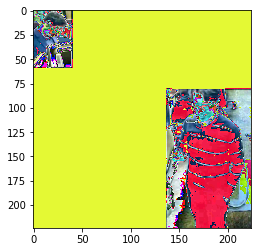

In [6]:
to_pil = torchvision.transforms.ToPILImage()
img = to_pil(val_ds[4][0])

imgplot = plt.imshow(img)
print(len(train_ds), len(val_ds))

In [7]:
# add our new model for three inputs

from nets.ResNet_ronorigin import *
model = resnet_18()

for param in model.parameters():
    param.requires_grad = True
    
# model = model.to(device)
model = torch.nn.DataParallel(model).cuda()
criterion = nn.CrossEntropyLoss()

NameError: name 'device' is not defined

# The Optimizer

In [22]:
optimizer = torch.optim.Adam(
    get_trainable(model.parameters()),
    # model.fc.parameters(),
    lr=0.001,
    # momentum=0.9,
)

# The Train Loop

In [23]:
N_EPOCHS = 10  #1  #2  #10

In [24]:
for epoch in range(N_EPOCHS):
    
    # start epoch
    start_time = time.time()
    start_datetime = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f"Epoch {epoch+1}/{N_EPOCHS}")
    print(f'  Start Time: {start_datetime}')
    
    # Train
    model.train()  # IMPORTANT
    
    running_loss, correct = 0.0, 0
    for X, y in train_dl:
        X, y = X.to(device), y.to(device)
        
        optimizer.zero_grad()
        # with torch.set_grad_enabled(True):
        y_ = model(X)
        loss = criterion(y_, y)

        loss.backward()
        optimizer.step()
        
        # Statistics
        print(f"    batch loss: {loss.item():0.3f}")
        _, y_label_ = torch.max(y_, 1)
        correct += (y_label_ == y).sum().item()
        running_loss += loss.item() * X.shape[0]
    
    print(f"  Train Loss: {running_loss / len(train_dl.dataset)}")
    print(f"  Train Acc:  {correct / len(train_dl.dataset)}")
    
    
    # Eval
    model.eval()  # IMPORTANT
    
    running_loss, correct = 0.0, 0
    with torch.no_grad():  # IMPORTANT
        for X, y in val_dl:
            X, y = X.to(device), y.to(device)
                    
            y_ = model(X)
        
            _, y_label_ = torch.max(y_, 1)
            correct += (y_label_ == y).sum().item()
            
            loss = criterion(y_, y)
            running_loss += loss.item() * X.shape[0]
    
    print(f"  Valid Loss: {running_loss / len(val_dl.dataset)}")
    print(f"  Valid Acc:  {correct / len(val_dl.dataset)}")
    
    # end epoch
    end_time = time.time()
    end_datetime = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    time_elapsed = end_time - start_time
    datetime_elapsed = str(datetime.timedelta(seconds = time_elapsed))
    print(f'  End Time: {end_datetime}')
    print(f'  Time Elapsed: {datetime_elapsed}')
    print()

Epoch 1/10
  Start Time: 2019-02-03 14:27:43
    batch loss: 4.922
    batch loss: 1.996
    batch loss: 0.794
    batch loss: 0.724
    batch loss: 0.597
    batch loss: 0.723


Traceback (most recent call last):
  File "/home/tuo/anaconda3/envs/caffe2_36/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/tuo/anaconda3/envs/caffe2_36/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/tuo/anaconda3/envs/caffe2_36/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/tuo/anaconda3/envs/caffe2_36/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/tuo/anaconda3/envs/caffe2_36/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/tuo/anaconda3/envs/caffe2_36/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/tuo/anaconda3/envs/caffe2_

KeyboardInterrupt: 

** -- above is the result of crop extent data set -- **

# Predict with Trained Model

Pickle the trained model and predict image with it. 

In [ ]:
# save the trained model weights
import os

root_path = os.path.abspath(os.pardir)

model_weights_path = root_path+'/data/saved_model_weights/resnet18_whole'

# !!!only use it when you WANT to save a trained model weights!!!
torch.save(model.state_dict(), model_weights_path)

In [ ]:
# load the trained model
from nets.ResNet_ronorigin import *
model = resnet_18()

for param in model.parameters():
    param.requires_grad = True
    
model = model.to(device)

model.load_state_dict(torch.load(model_weights_path))

In [ ]:
# use trained model to predict a pair of people in a new image

# test data set
test_ds = ImageFolder(root_path+"/data/raw/DUI/test", transform=val_trans, loader=default_loader)
print(f'len(test_ds) = {len(test_ds)}. ')

test_dl = DataLoader(
    test_ds,xx
    batch_size=1,
    shuffle=False,
    num_workers=4,
)

print(f'test_ds[99]: \n{test_ds[99]}')
print(f'test_ds[99][1]: \n{test_ds[99][1]}')

In [ ]:
# predict

# Eval
model.eval()  # IMPORTANT

with torch.no_grad():  # IMPORTANT
    for X, y in test_dl:
        X, y = X.to(device), y.to(device)
        print(f'y: \t\t\t{y}')

        y_ = model(X)
        _, y_label_ = torch.max(y_, 1)
        print(f'y_label_: \t\t{y_label_}')
        
        is_correct = 'correct' if y_label_ == y else 'wrong'
        print(f'is_correct: \t{is_correct}\n')

#print(f"  Valid Loss: {running_loss / len(val_dl.dataset)}")
#print(f"  Valid Acc:  {correct / len(val_dl.dataset)}")